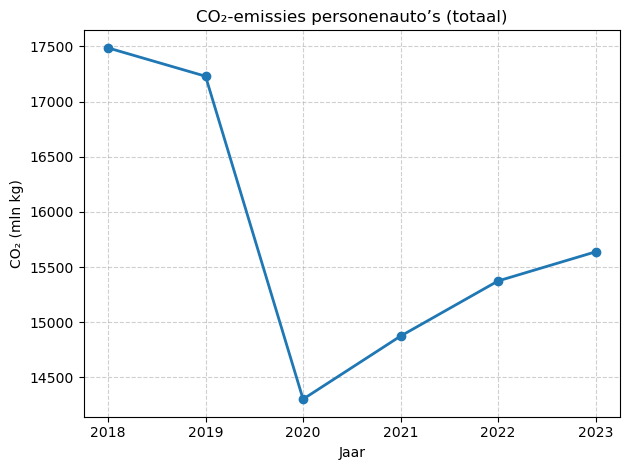

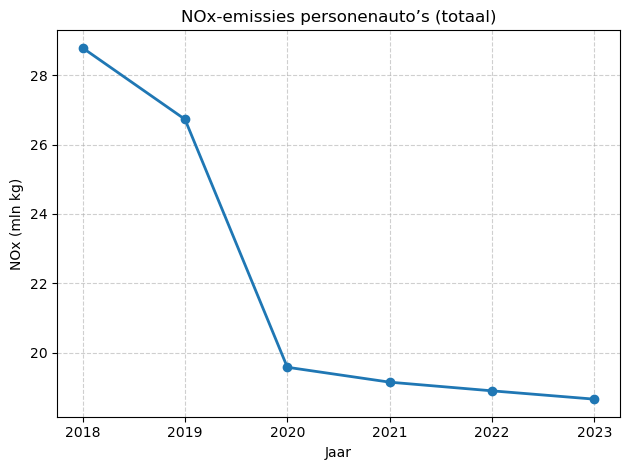

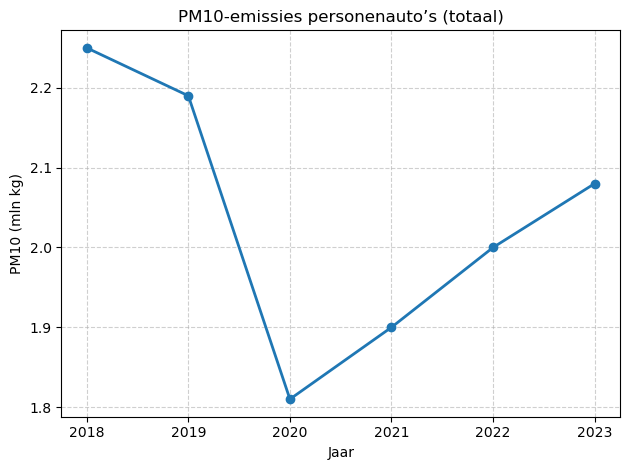


Tabel: kilometers (mln km), totalen (mln kg) en intensiteiten (g/km)
 Jaar   km_mln  CO2_mlnkg  NOx_mlnkg  PM10_mlnkg  CO2_g_per_km  NOx_g_per_km  PM10_g_per_km
 2018 109337.4      17487      28.79        2.25    159.936124      0.263313       0.020579
 2019 109086.8      17230      26.73        2.19    157.947616      0.245034       0.020076
 2020  91723.0      14302      19.58        1.81    155.925995      0.213469       0.019733
 2021  96988.8      14874      19.15        1.90    153.357913      0.197445       0.019590
 2022 102679.6      15374      18.90        2.00    149.727891      0.184068       0.019478
 2023 107143.1      15638      18.66        2.08    145.954336      0.174160       0.019413


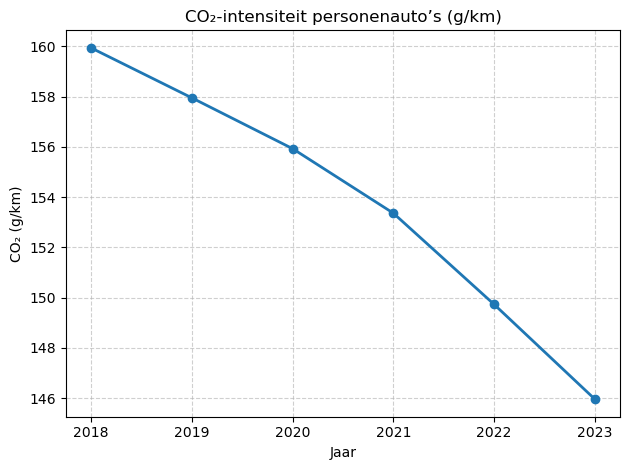

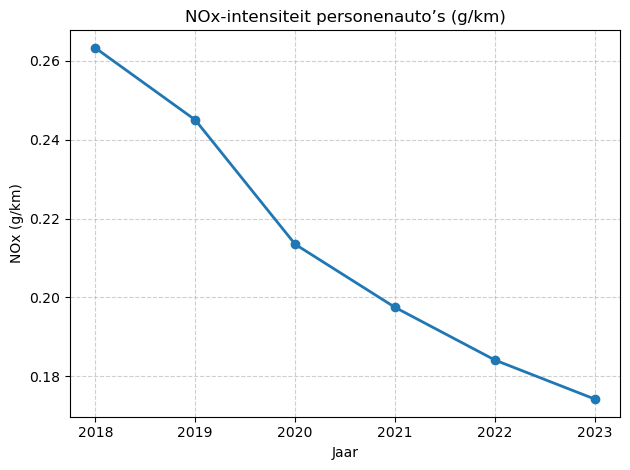

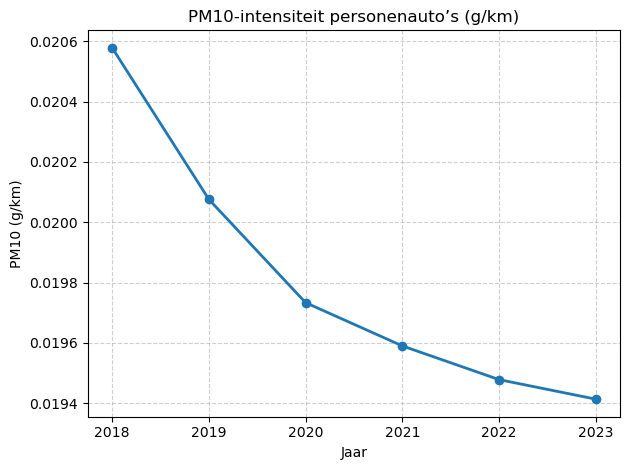

In [11]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# ========= Paden naar je bestanden (jouw input) =========
path_emissies = r"C:\Users\TRGul\Downloads\Emissies_Nederland__wegverkeer_13102025_110220.csv"
path_km       = r"C:\Users\TRGul\Downloads\Verkeer_motorvoertuigen_13102025_105929.csv"
electric_vehicles = r"C:\Users\TRGul\Downloads\Procentuele aandeel BEV_ FCEV en PHEV personenauto's in het wagenpark.csv"

# ========= Helpers =========
def find_col(df, startswith):
    """Zoek kolom die met 'startswith' begint (CBS wisselt soms subtitels)."""
    for c in df.columns:
        if str(c).startswith(startswith):
            return c
    return None

def plot_line(years, values, title, ylabel):
    """Eenvoudige lijngrafiek met 1 y-as."""
    plt.figure()
    plt.plot(years, values, marker='o', linewidth=2)
    plt.title(title)
    plt.xlabel("Jaar")
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# ========= 1) Inlezen CSV’s =========
df_e = pd.read_csv(path_emissies, sep=';', encoding='utf-8-sig', quotechar='"', decimal=',')
df_km = pd.read_csv(path_km,       sep=';', encoding='utf-8-sig', quotechar='"', decimal=',')

# ========= 2) Emissies voorbereiden (personenauto’s) =========
# Vind kolommen voor CO2/NOx/PM10 (mln kg)
co2_col  = find_col(df_e, "Emissies/Kooldioxide (CO2)")
nox_col  = find_col(df_e, "Emissies/Stikstofoxiden (NOx)")
pm10_col = find_col(df_e, "Emissies/PM10 Totaal")
if not all([co2_col, nox_col, pm10_col]):
    raise ValueError("Kon CO₂/NOx/PM10-kolommen niet vinden in het emissies-bestand.")

# Filter personenauto's (let op apostrof) en pak jaren 2018–2023
d_e = df_e[df_e['Voertuigtype'] == "Personenauto's"].copy()
d_e['Jaar'] = d_e['Perioden'].astype(str).str.extract(r'(\d{4})').astype(int)
d_e = d_e[(d_e['Jaar'] >= 2018) & (d_e['Jaar'] <= 2023)]

# Houd relevante kolommen en hernoem
d_e = d_e[['Jaar', co2_col, nox_col, pm10_col]].rename(columns={
    co2_col:  'CO2_mlnkg',
    nox_col:  'NOx_mlnkg',
    pm10_col: 'PM10_mlnkg'
}).sort_values('Jaar')

# ========= 3) KILOMETERS uit 2e CSV (Personenauto, totaal in NL) =========
# In tweede CSV heet het doorgaans 'Voertuigtypes' en 'Personenauto' (zonder 's)
km_total_col = find_col(df_km, "Kilometers in Nederland/Totaal kilometers in Nederland")
if not km_total_col:
    raise ValueError("Kon kolom 'Kilometers in Nederland/Totaal kilometers in Nederland (x mln km)' niet vinden in km-bestand.")

d_km = df_km[df_km['Voertuigtypes'] == 'Personenauto'].copy()
d_km['Jaar'] = d_km['Perioden'].astype(str).str.extract(r'(\d{4})').astype(int)
d_km = d_km[['Jaar', km_total_col]].rename(columns={km_total_col: 'km_mln'}).sort_values('Jaar')

# ========= 4) EERST: DRIE LOSSE PLOTS – ALLEEN TOTAAL (mln kg) =========
plot_line(d_e['Jaar'], d_e['CO2_mlnkg'], "CO₂-emissies personenauto’s (totaal)", "CO₂ (mln kg)")
plot_line(d_e['Jaar'], d_e['NOx_mlnkg'], "NOx-emissies personenauto’s (totaal)", "NOx (mln kg)")
plot_line(d_e['Jaar'], d_e['PM10_mlnkg'], "PM10-emissies personenauto’s (totaal)", "PM10 (mln kg)")

# ========= 5) Samenvoegen met kilometers + intensiteiten (g/km) =========
df = d_e.merge(d_km, on='Jaar', how='inner')

# g/km = (mln kg * 1000) / (mln km)
df['CO2_g_per_km']  = (df['CO2_mlnkg']  * 1000) / df['km_mln']
df['NOx_g_per_km']  = (df['NOx_mlnkg']  * 1000) / df['km_mln']
df['PM10_g_per_km'] = (df['PM10_mlnkg'] * 1000) / df['km_mln']

# ========= 6) Toon tabel (kilometers, totalen, intensiteiten) =========
print("\nTabel: kilometers (mln km), totalen (mln kg) en intensiteiten (g/km)")
print(df[['Jaar', 'km_mln', 'CO2_mlnkg', 'NOx_mlnkg', 'PM10_mlnkg',
          'CO2_g_per_km', 'NOx_g_per_km', 'PM10_g_per_km']].to_string(index=False))

# ========= 7) Tot slot: DRIE LOSSE PLOTS – ALLEEN INTENSITEIT (g/km) =========
plot_line(df['Jaar'], df['CO2_g_per_km'],  "CO₂-intensiteit personenauto’s (g/km)",  "CO₂ (g/km)")
plot_line(df['Jaar'], df['NOx_g_per_km'],  "NOx-intensiteit personenauto’s (g/km)",  "NOx (g/km)")
plot_line(df['Jaar'], df['PM10_g_per_km'], "PM10-intensiteit personenauto’s (g/km)", "PM10 (g/km)")


In [6]:
import numpy as np

def trend_stats(df_in, years=(2018, 2023)):
    # snijd op gewenste jaren en drop NaN
    d = df_in[(df_in['Jaar'] >= years[0]) & (df_in['Jaar'] <= years[1])].copy()
    d = d[['Jaar','CO2_g_per_km','NOx_g_per_km','PM10_g_per_km']].dropna()
    d = d.sort_values('Jaar')

    if d.empty or len(d) < 2:
        return None

    y0, y1 = d['Jaar'].iloc[0], d['Jaar'].iloc[-1]
    n_years = y1 - y0  # aantal jaarstappen voor CAGR

    out = {}
    for pol in ['CO2_g_per_km','NOx_g_per_km','PM10_g_per_km']:
        v0 = d[pol].iloc[0]
        v1 = d[pol].iloc[-1]
        pct = (v1 - v0) / v0 * 100.0
        cagr = (v1 / v0)**(1/n_years) - 1 if v0 > 0 and n_years > 0 else np.nan
        # lineaire slope (g/km per jaar)
        b1, b0 = np.polyfit(d['Jaar'].values, d[pol].values, 1)
        out[pol] = {'start': v0, 'end': v1, 'pct_change_%': pct, 'cagr_%py': cagr*100, 'slope_gpkm_per_year': b1}
    return out

def pretty_compare(stats, label):
    if stats is None:
        print(f"[{label}] Onvoldoende data.")
        return
    print(f"\n=== Trendvergelijking {label} ===")
    for pol, s in stats.items():
        print(f"{pol.replace('_g_per_km',''):5s}: start={s['start']:.3f}, end={s['end']:.3f}, "
              f"Δ%={s['pct_change_%']:.2f}%, CAGR={s['cagr_%py']:.2f}%/yr, slope={s['slope_gpkm_per_year']:.4f} g/km/yr")

    # “Sneller dalen” = grotere (absoluut) negatieve daling dan CO2
    def faster_than_CO2(metric):
        co2 = stats['CO2_g_per_km'][metric]
        nox = stats['NOx_g_per_km'][metric]
        pm  = stats['PM10_g_per_km'][metric]
        def verdict(x):  # True = sneller dalen dan CO2
            # we nemen "sneller dalen" als: meer negatief dan CO2 (kleiner getal)
            return x < co2
        return verdict(nox), verdict(pm)

    for metric, labelm in [('pct_change_%', 'percentuele daling (2018→2023)'),
                           ('cagr_%py',     'CAGR (per jaar)'),
                           ('slope_gpkm_per_year','lineaire slope')]:
        nox_fast, pm_fast = faster_than_CO2(metric)
        print(f"- Op basis van {labelm}: "
              f"NOx {'daalt sneller' if nox_fast else 'niet sneller'} dan CO₂; "
              f"PM10 {'daalt sneller' if pm_fast else 'niet sneller'} dan CO₂.")

# 8a) Met alle jaren (2018–2023)
stats_all = trend_stats(df, (2018, 2023))
pretty_compare(stats_all, "inclusief 2020")

# 8b) Robuustheid: zonder 2020
df_no2020 = df[df['Jaar'] != 2020].copy()
stats_no2020 = trend_stats(df_no2020, (2018, 2023))
pretty_compare(stats_no2020, "exclusief 2020")


=== Trendvergelijking inclusief 2020 ===
CO2  : start=159.936, end=145.954, Δ%=-8.74%, CAGR=-1.81%/yr, slope=-2.7753 g/km/yr
NOx  : start=0.263, end=0.174, Δ%=-33.86%, CAGR=-7.93%/yr, slope=-0.0184 g/km/yr
PM10 : start=0.021, end=0.019, Δ%=-5.66%, CAGR=-1.16%/yr, slope=-0.0002 g/km/yr
- Op basis van percentuele daling (2018→2023): NOx daalt sneller dan CO₂; PM10 niet sneller dan CO₂.
- Op basis van CAGR (per jaar): NOx daalt sneller dan CO₂; PM10 niet sneller dan CO₂.
- Op basis van lineaire slope: NOx niet sneller dan CO₂; PM10 niet sneller dan CO₂.

=== Trendvergelijking exclusief 2020 ===
CO2  : start=159.936, end=145.954, Δ%=-8.74%, CAGR=-1.81%/yr, slope=-2.7499 g/km/yr
NOx  : start=0.263, end=0.174, Δ%=-33.86%, CAGR=-7.93%/yr, slope=-0.0187 g/km/yr
PM10 : start=0.021, end=0.019, Δ%=-5.66%, CAGR=-1.16%/yr, slope=-0.0002 g/km/yr
- Op basis van percentuele daling (2018→2023): NOx daalt sneller dan CO₂; PM10 niet sneller dan CO₂.
- Op basis van CAGR (per jaar): NOx daalt sneller dan 

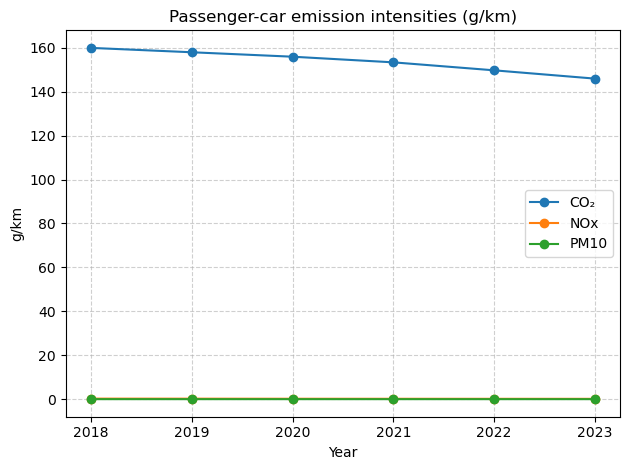

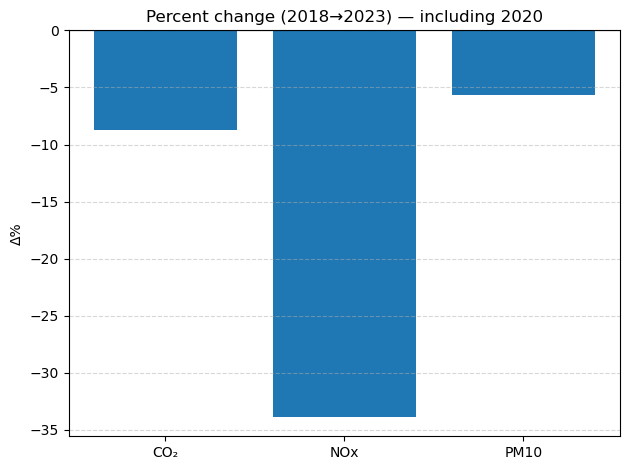

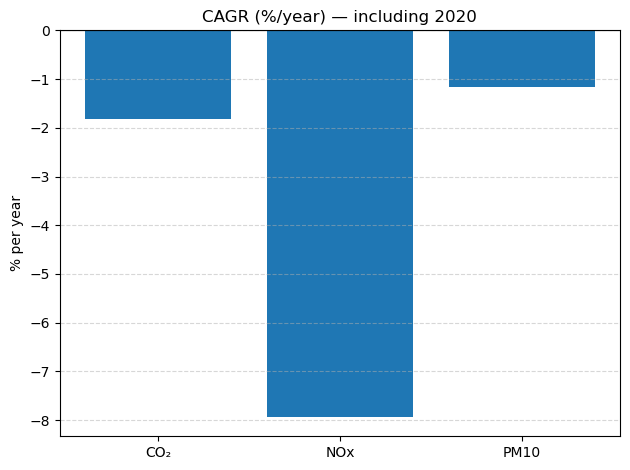

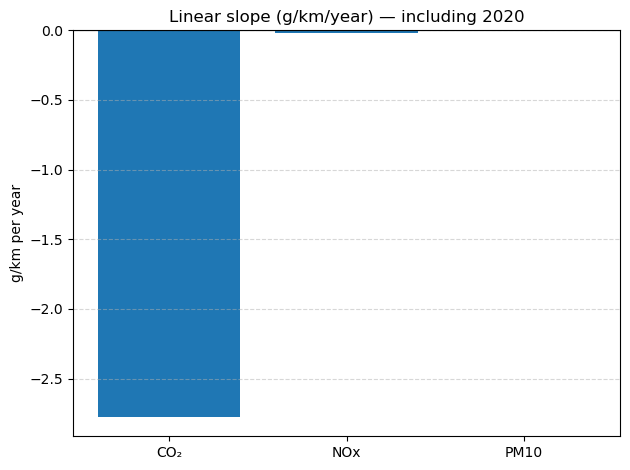

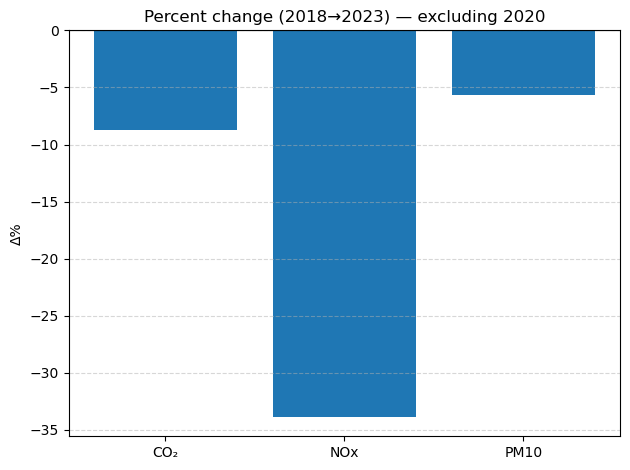

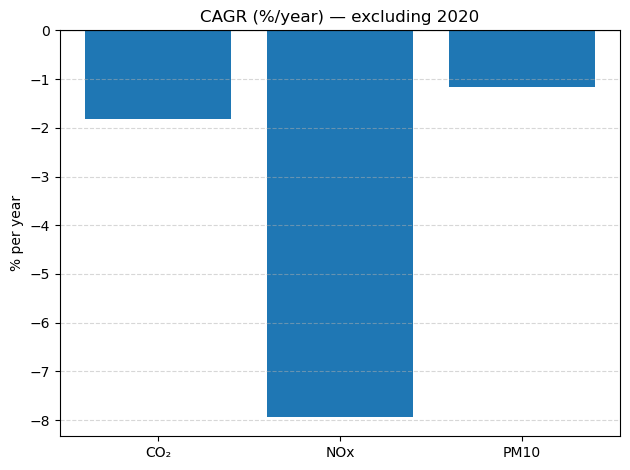

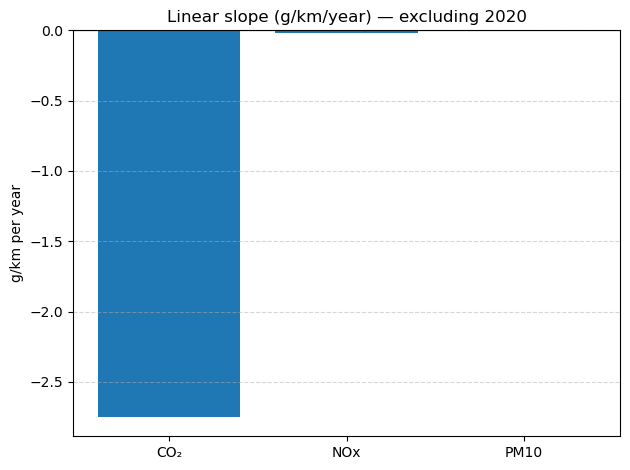

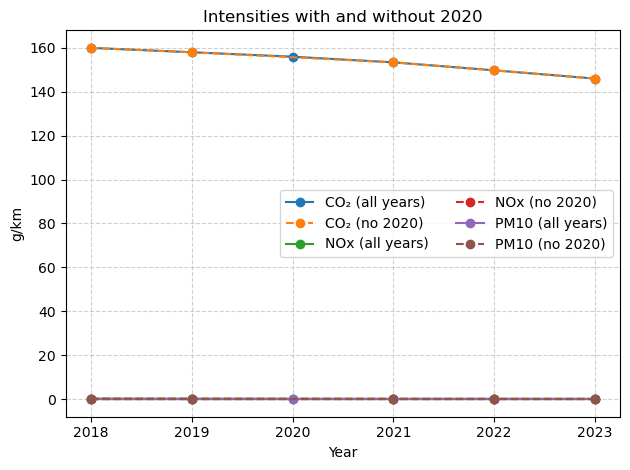

In [7]:
# ========= 9) Visualisaties van trends & vergelijkingen =========
import matplotlib.pyplot as plt
import numpy as np

# 9a) Tijdreeks: intensiteiten 2018–2023
plt.figure()
plt.plot(df['Jaar'], df['CO2_g_per_km'],  marker='o', label='CO₂')
plt.plot(df['Jaar'], df['NOx_g_per_km'],  marker='o', label='NOx')
plt.plot(df['Jaar'], df['PM10_g_per_km'], marker='o', label='PM10')
plt.title('Passenger-car emission intensities (g/km)')
plt.xlabel('Year'); plt.ylabel('g/km'); plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(); plt.tight_layout(); plt.show()

# 9b) Hulpfunctie: barplot voor Δ%, CAGR en slope uit de stats-dicts
def plot_stats_bars(stats_dict, title_suffix):
    if stats_dict is None: 
        print(f"[{title_suffix}] No data to plot."); 
        return
    labels = ['CO₂','NOx','PM10']
    keys   = ['CO2_g_per_km','NOx_g_per_km','PM10_g_per_km']

    # Verzamel waarden
    pct   = [stats_dict[k]['pct_change_%'] for k in keys]
    cagr  = [stats_dict[k]['cagr_%py']     for k in keys]
    slope = [stats_dict[k]['slope_gpkm_per_year'] for k in keys]

    # Bar 1: percentuele verandering 2018→2023
    plt.figure()
    x = np.arange(len(labels))
    plt.bar(x, pct)
    plt.xticks(x, labels)
    plt.axhline(0, color='k', linewidth=0.8)
    plt.title(f'Percent change (2018→2023) — {title_suffix}')
    plt.ylabel('Δ%'); plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()

    # Bar 2: CAGR (%/jaar)
    plt.figure()
    plt.bar(x, cagr)
    plt.xticks(x, labels)
    plt.axhline(0, color='k', linewidth=0.8)
    plt.title(f'CAGR (%/year) — {title_suffix}')
    plt.ylabel('% per year'); plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()

    # Bar 3: Lineaire slope (g/km/jaar)
    plt.figure()
    plt.bar(x, slope)
    plt.xticks(x, labels)
    plt.axhline(0, color='k', linewidth=0.8)
    plt.title(f'Linear slope (g/km/year) — {title_suffix}')
    plt.ylabel('g/km per year'); plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()

# 9c) Maak de vergelijkingsplots (incl. en excl. 2020)
plot_stats_bars(stats_all,    'including 2020')
plot_stats_bars(stats_no2020, 'excluding 2020')

# (Optioneel) 9d) Tijdreeks zonder 2020 als extra lijn
df_ex = df[df['Jaar'] != 2020]
plt.figure()
plt.plot(df['Jaar'],    df['CO2_g_per_km'],  marker='o', label='CO₂ (all years)')
plt.plot(df_ex['Jaar'], df_ex['CO2_g_per_km'],  marker='o', linestyle='--', label='CO₂ (no 2020)')
plt.plot(df['Jaar'],    df['NOx_g_per_km'],  marker='o', label='NOx (all years)')
plt.plot(df_ex['Jaar'], df_ex['NOx_g_per_km'],  marker='o', linestyle='--', label='NOx (no 2020)')
plt.plot(df['Jaar'],    df['PM10_g_per_km'], marker='o', label='PM10 (all years)')
plt.plot(df_ex['Jaar'], df_ex['PM10_g_per_km'], marker='o', linestyle='--', label='PM10 (no 2020)')
plt.title('Intensities with and without 2020')
plt.xlabel('Year'); plt.ylabel('g/km'); plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(ncol=2); plt.tight_layout(); plt.show()
